# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: M. Massias, P. Ablin

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal gradient descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 11th of november at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 5 novembre 2017**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "salma"
ln1 = "jeridi"
fn2 = "aymen"
ln2 = "dabghi"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_jeridi_salma_and_dabghi_aymen.ipynb


In [142]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b, fmin_cg
import seaborn as sns
sns.set()

In [3]:
# the usual functions:

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b


## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$

We ask you to code:
- cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$
- greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.


**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [128]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [5]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    residuals = b - A.dot(w)
    
    # TODO
    lips_const = [norm(A[:,i] , ord=2) ** 2 for i in range(A.shape[1])]
    # END TODO
    
    for t in range(n_iter):
        j = t % n_features
        # TODO
        old_w_j = w[j]
        w[j] += A[:,j].dot(residuals) / lips_const[j]
        # update residuals:
        residuals += A[:,j] * old_w_j - A[:,j] * w[j]
        # END TODO
        
        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
           
    return w, np.array(all_objs)



def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    
    w = np.zeros(n_features)
    
    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date
    
    # TODO
    lips_const = [norm(A[:,i] , ord=2) ** 2 for i in range(A.shape[1])]
    # END TODO 
    
    for t in range(n_iter):
        # TODO
        # choose feature j to update: 
        j = np.argmax(abs(gradient))
        old_w_j = w[j]
        w[j] -= 1/lips_const[j] * gradient[j]
        # update gradient:
        gradient += gram[:,j] * w[j] - gram[:,j] * old_w_j
        # END TODO
        
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)
           
    return w, np.array(all_objs)

- compute a precise minimum with your favorite solver
- compare the performance of cyclic and greedy CD

- could you use greedy CD for unregularized logistic regression? for OLS, but with 100,000 features? Explain your answers.

In [129]:
# We will compute a precise minimum with the scipy.optimize.fmin_l_bfgs_b
# The functions below are from the previous lab

def loss(x, A, b):
    return norm(A.dot(x) - b) ** 2 / 2

def grad(x, A, b):
    """Full gradient"""
    return A.T.dot(A.dot(x)-b)

In [130]:
w_init = np.zeros(n_features)
# x_min , f_min  will be considered as refrences to calculate distance to the minimum and for cyclic and greedy CD 
w_min, f_min, _ = fmin_l_bfgs_b(loss, w_init, grad, args=(A, b), pgtol=1e-30, factr=1e-30)


In [33]:
import time
start_time = time.time()
w_c , obj_c  = cyclic_cd(A,b,3000)
print("--- cyclic %s seconds ---" % (time.time() - start_time))
start_time = time.time()
w_g , obj_g  = greedy_cd(A,b,3000)
print("--- greedy %s seconds ---" % (time.time() - start_time))

--- cyclic 0.0702369213104248 seconds ---
--- greedy 0.03371095657348633 seconds ---


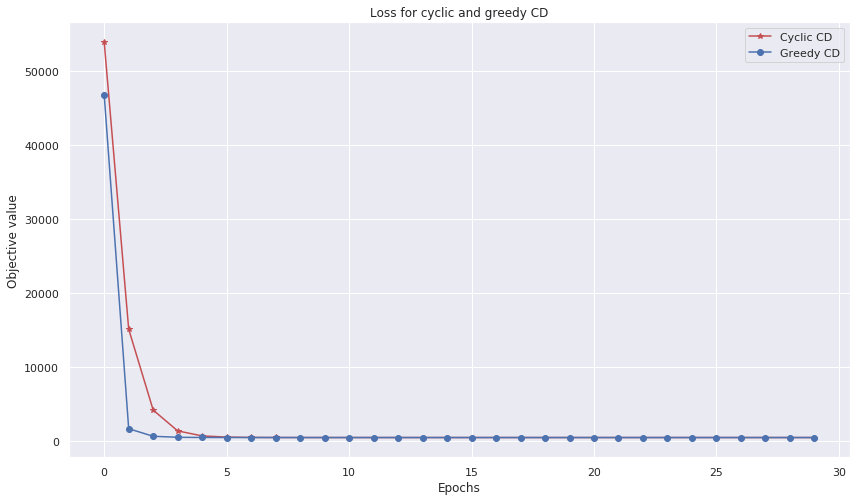

In [38]:
#plot objectives for greedy and cyclic CD
plt.figure(figsize=(14,8))
plt.plot(obj_c  , 'r*-', label="Cyclic CD")
plt.plot(obj_g , 'o-',label="Greedy CD")
plt.title('Loss for cyclic and greedy CD')
plt.xlabel('Epochs')
plt.ylabel('Objective value')

plt.legend()
plt.show()

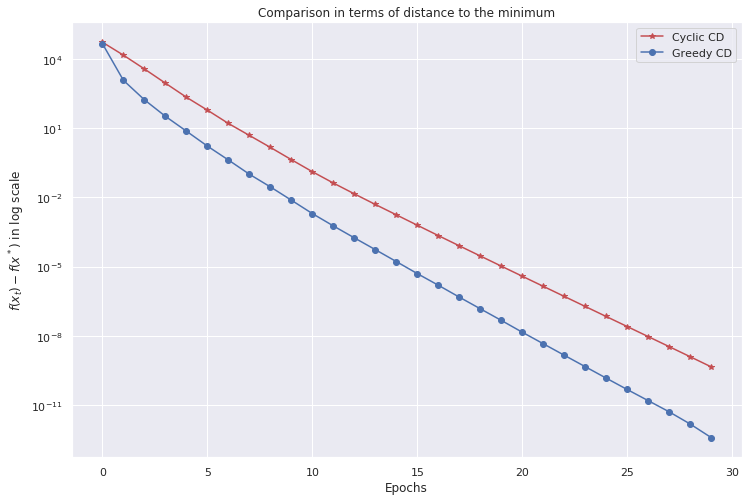

In [35]:
#Comparison in terms of distance to f_min 

plt.figure(figsize=(12,8))

plt.semilogy(obj_c - f_min , 'r*-',label="Cyclic CD")
plt.semilogy(obj_g -f_min , 'o-',label="Greedy CD")

plt.xlabel("Epochs")
plt.ylabel("$f(x_t) - f(x^*)$ in log scale")
plt.legend()
plt.title("Comparison in terms of distance to the minimum")

    

plt.show()

In [36]:
#distance to the minimizer obtained with fmin_l_bfgs_b
print ("error rate for cyclic CD : "+ str(norm(w_c-w_min, ord=2)))
print ("error rate for greedy CD : "+ str(norm(w_g-w_min, ord=2)))

error rate for cyclic CD : 1.1469214564148751e-06
error rate for greedy CD : 3.7111671879831406e-08


<div class="alert alert-info">
<strong>$\rightarrow$  Comparison : </strong>  

<br>
$\bullet$  The graphs show that :   
- The objective decrease for each iteration of CD with Cyclic and Greedy schemes of coordiante selection, to reach both the value of 466.38497653.   
- After 3000 iterations, the distance to the minimum for cyclic CD algorithm is of the order of $10^{-10}$ while for greedy CD is of the order of $10^{-12}$ .  
- The final error rates, comparing w_c and w_g to w_min obtained with fmin_l_bfgs_b , are of the order of $10^{-6}$ and $10^{-8}$ respectively.     
$\rightarrow$ We notice that Greedy CD outperforms Cyclic CD, it converges in less number of iterations.This can be explained by the fact that GCD, by construction, opts to select a good, instead of cyclic, coordinate that yield better reduction of objective function value.In our case the selection relies on magnitudes of the gradient components. Since the variable is carefully selected, at each iteration GCD can reduce objective function more than CCD which leads to faster convergence in practice.  
<br>

$\bullet$ <strong>Greedy CD for OLS with 100000 features :</strong> Greedy CD method requires evaluating the whole gradient vector to find the greatest descent and get the best index. With a big number of features ( 100000) this could be expensive in terms of computational time because it introduces a higher per-iteration complexity, even if the gradient can be updated at a low cost (in a clever way) .   
<br>

$\bullet$  <strong>Greedy CD for unregularized Logistic regression :</strong> In unregularized problems the big number of non zero components causes the non efficiency of GCD as it has to go through every variable in order to find the greatest gradient. GCD is more effcient with regularized problemes, meaning for sparse optimization since most zero components in the solution are never selected and thus remain zero throughout the iterations. The problem dimension effectively reduces the number of variables that are ever updated, which is relatively small. Consequently, the greedy CD iteration converges in very few iterations. The saved iterations over-weigh the extra cost of ranking the coordinates.

</div>


## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$
1) Show that:
$$ \lambda \geq \lambda_{max} \implies \hat w = 0$$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.


You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert_1 (w_1)  \times \dots \times \partial \vert \cdot \vert_1 (w_p) $$
where $\times$ is the Cartesian product between sets,
and $$ \partial \vert \cdot \vert_1 (w_1) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

<div class="alert alert-info">
    <b>Answer</b>:  

We start by computing the differential of our objective function :  
$$f=\sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$  
$$\partial f(w)=\sum_{i=1}^{n} \frac{-y_i x_i^\top}{1+\exp(y_i w^\top x_i)} + \lambda \partial \Vert . \Vert_1(w) $$


We have $\lambda \geq \lambda_{max}$ where $\lambda_{max} = \frac 12 \Vert X^\top y \Vert_{\infty}$  
Let $ v = \frac 12 X^\top y =$ where $ v = (\alpha_1,\ldots,\alpha_n)$  
Then $\lambda_{max} = \max_{i}(\alpha_i)$  
$\begin{alignat}{2}
\lambda \geq \lambda_{max} 
&\Rightarrow \forall i \in \{1,\ldots,n\} ; \lambda \geq |\alpha_i| \\ 
&\Rightarrow \alpha_i \in \lambda[-1,1] \\
&\Rightarrow v \in \lambda([-1,1] \times \ldots \times [-1,1])
\end{alignat}$  
  
However, we know from the beautiful result above that : $\partial\Vert.\Vert_1(0_p)=[-1,1] \times \ldots \times [-1,1]$  
So : $v \in \partial\Vert.\Vert_1(0_p) \Rightarrow 0\in \{-v\} + \lambda\partial\Vert.\Vert_1(0_p)$  

This reminds us of the subdifferential computed above applied on 0 :
$$\partial f(0)=-\frac 12 \{X^\top y\}+\partial\Vert.\Vert_1(0_p)$$  
Therefore :  $$0 \in \partial f(0)$$  
And according to Fermat's rule, if $f$ is a convex function, then $0 \in \arg\min f$  

$\underline{Proof of convexity}$ :  
We know that $\Vert . \Vert_1$ is convex  
In order to prove that the first term of f is convex, we compute its Hessian :  
$$H= \sum_{i=1}^{n} \frac{y_i^2 x_i^\top x_i \exp(y_i w^\top x_i)}{(1+\exp(y_i w^\top x_i))^2}$$  
Let $b \in \mathbf{R^n}$, then :  
$$b^\top x_i x_i^\top b=\Vert x_i^\top b\Vert ^2 \geq 0$$  
Therefore : $$H\geq 0$$  
Conclusion : $f$ is convex and $ \hat w = 0$
</div>

2) Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.

<div class="alert alert-info">  
    <b>Answer</b>:  

In this question, we denote by $f$ the following function :  

$$f(w)=\sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )$$  

Then we compute the derivative of $f$ according to $w_j$ :  

$$\frac {\partial f(w)}{\partial w_j}=\sum_{i=1}^{n} \frac{-y_i x_{ij}}{1+\exp(y_i w^\top x_i)}$$  

And then the second :  

$$\frac {\partial^2 f(w)}{\partial w_j^2}=\sum_{i=1}^{n} \frac{y_i^2 x_{ij}^2 \exp(y_i w^\top x_i)}{(1+\exp(y_i w^\top x_i))^2}$$  

However, we already know that :  

$$ \frac {\exp \alpha}{(1+\exp \alpha)^2} \leq \frac 14 \forall \alpha$$

And : $$y_i^2 = 1 \quad \forall i$$  

So : $$\frac {\partial^2 f(w)}{\partial w_j^2} \leq \frac 14 \sum_{i=1}^{n} x_{ij}^2 = \frac 14 \Vert X_j \Vert ^2 = L_j $$




#### We will implement the cyclic proximal coordinate descent, with $\frac{||X_j||^2}{4}$ as the Lipschitz constant :

In [272]:
# Generating X and y and fixing lambda
n_features = 100
X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max / 10.  
# much easier to parametrize lambda as a function of lambda_max than 
# to take random values like 0.1 in previous Labs

In [273]:
def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.maximum(0., np.abs(x) - u)

In [274]:
def cd_logreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)
    
    # TODO
    lips_const = [norm(X[:,j] , ord=2)**2 / 4 for j in range(n_features)]
    # END TODO
    all_objs = np.zeros(n_iter)
    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            # TODO
            grad_j = -sum([y[i] * X[i,j] * sigmoid(-y[i]*Xw[i]) for i in range(n_samples)])
            w[j] = np.sign(w[j] - grad_j/lips_const[j]) * soft_thresh(w[j] - grad_j/lips_const[j], lamb/lips_const[j])
            
            if old_w_j != w[j]:
                Xw += w[j] * X[:,j] - old_w_j * X[:,j]
            #END TODO
            
        all_objs[t] = np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1)
    
    return w, all_objs

In [276]:
w , all_objs_lc = cd_logreg(X,y,lamb,n_iter=10)

**Bonus**: show that is possible, when the current iterate is w, to use the better Lipschitz constant 
    $$L_j = \sum_{i=1}^n  \frac{X_{i, j}^2 \mathrm{e}^{(Xw)_i}}{(1 +
\mathrm{e}^{(Xw)_i})^2}$$
    
(why is it better?)

 

<div class="alert alert-info">  
    <b>Answer</b>: 

$$\sum_{i=1}^{n} \frac{y_i^2 x_{ij}^2 \exp(y_i w^\top x_i)}{(1+\exp(y_i w^\top x_i))^2} \leq \sum_{i=1}^{n} \frac{x_{ij}^2 \exp(w^\top x_i)}{(1+\exp(w^\top x_i))^2}$$

because $y_i = \pm 1$ and therefore $\vert y_i w^\top x_i \vert = \vert w^\top x_i  \vert$  

$$L_j = \sum_{i=1}^{n} \frac{x_{ij}^2 \exp(w^\top x_i)}{(1+\exp(w^\top x_i))^2} \leq \frac {\Vert X_j \Vert}4  $$

The new Lipschitz constant is better because it is simply smaller, and then the step taken by the algorithm becomes bigger, and the algorithm is able to reach better reduction of the objective function.  
</div>


**Here we will implement it in the code with a `better_lc` parameter**

In [294]:
def cd_logreg_better(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)
    
    all_objs = np.zeros(n_iter)
    for t in range(n_iter):

        for j in range(n_features):
            
            lips_const = sum([X[i,j]**2 * np.exp(Xw[i]) * sigmoid(-Xw[i])**2 for i in range(n_samples)]) 
            old_w_j = w[j]
            # TODO
            grad_j = -sum([y[i] * X[i,j] * sigmoid(-y[i]*Xw[i]) for i in range(n_samples)])
            w[j] = np.sign(w[j] - grad_j/lips_const) * soft_thresh(w[j] - grad_j/lips_const, lamb/lips_const)
            
            if old_w_j != w[j]:
                Xw += w[j] * X[:,j] - old_w_j * X[:,j]
            #END TODO
            
        all_objs[t] = np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1)
    
    return w, all_objs

In [ ]:

w_, all_objs_lcbetter = cd_logreg_better(X,y,lamb,n_iter=10)


**Here we will compare the performance of cyclic proximal coordinate with normal and better lipschitz constant in terms of distance to the last minimum obtained with better lc**

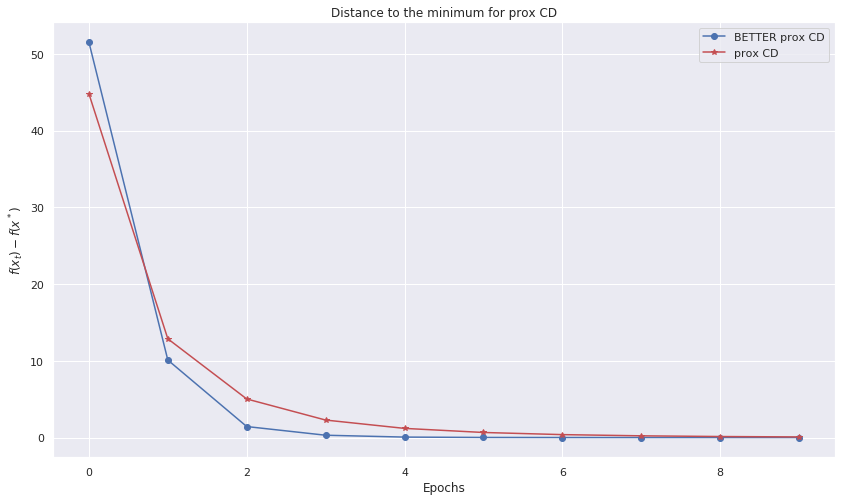

In [314]:

v= [norm(a-all_objs_lcbetter[-1]) for a in all_objs_lcbetter]
w=[norm(a-all_objs_lcbetter[-1]) for a in all_objs_lc]
plt.figure(figsize=(14,8))
plt.plot(v, 'o-',label="BETTER prox CD")
plt.plot(w, 'r*-', label="prox CD")

plt.title('Distance to the minimum for prox CD')
plt.xlabel('Epochs')
plt.ylabel('$f(x_t) - f(x^*)$')

plt.legend()
plt.show()

<div class="alert alert-info">
$\rightarrow$  We notice that both algorithms converge to the same minimum, however, prox CD with better_lc converges in less number of iterations despite its long computational time. In fact, at each step it has to update the lipschitz constant which implies highest per iteration complexity but with this better_lc it is able to reach better reduction of objective function at each iteration. 
</div>

# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

You can download the file here: http://web.stanford.edu/~hastie/CASI_files/DATA/leukemia_big.csv, and you should place it in the same folder as the current notebook.

In [317]:
from numpy import genfromtxt
y = 2 * (genfromtxt('leukemia_big.csv', delimiter=',', dtype=str)[0] == 'ALL') - 1
X = genfromtxt('leukemia_big.csv', delimiter=',')[1:].T

print(X.shape)
print(y[::10])

(72, 7128)
[ 1  1 -1 -1  1  1  1 -1]


In [318]:
lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso /5
n_samples, n_features = X.shape
n=n_samples

In [319]:
# To implement Ista , we used materials from the first lab
def prox_lasso(x, s):
    """Proximal operator for the Lasso at x"""  
    return np.sign(x) * np.maximum((np.abs(x) - s) , 0) 
    
def lasso(x, s):
    """Value of the Lasso penalization at x"""
    return s * np.linalg.norm(x , ord=1)
def loss_logreg(x):
    """Logistic loss"""
  
    return sum([np.log(1 + np.exp(-y[i]*np.dot(X[i],x))) for i in range(n_samples)] )

def grad_logreg(x):
    """Logistic gradient"""
    return -sum([y[i] * X[i,:].T * sigmoid(-y[i]*X[i].dot(x)) for i in range(n_samples)]) 

def lip_logreg(A):
    """Lipschitz constant for logistic loss"""    
    return  (1/4) * norm(A , ord=2) ** 2
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = X.shape

    # objective history
    objectives = []
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x = prox_g(x - (1/step) * grad_f(x) , s/step)
        
        obj = f(x) + g(x, s)
        objectives.append(obj)
        if k % 100 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8) ]))
#                               ("%.2e" % err).rjust(8)
    return x, objectives

In [320]:
# ista results 
w0=np.zeros(n_features)
w_ista ,obj_ista =ista(w0,loss_logreg,grad_logreg,lasso,prox_lasso,step=lip_logreg(X),s=lambd,n_iter=10*n_features, 
                      verbose=False)

In [321]:
#better prox cd results
w_prox, all_objs_prox = cd_logreg_better(X,y,lambd,n_iter=10)

In [353]:
v= [norm(ob-all_objs_prox[-1] ) for ob in all_objs_prox]
w= [norm(ob-all_objs_prox[-1] ) for ob in obj_ista[: :n_features]]

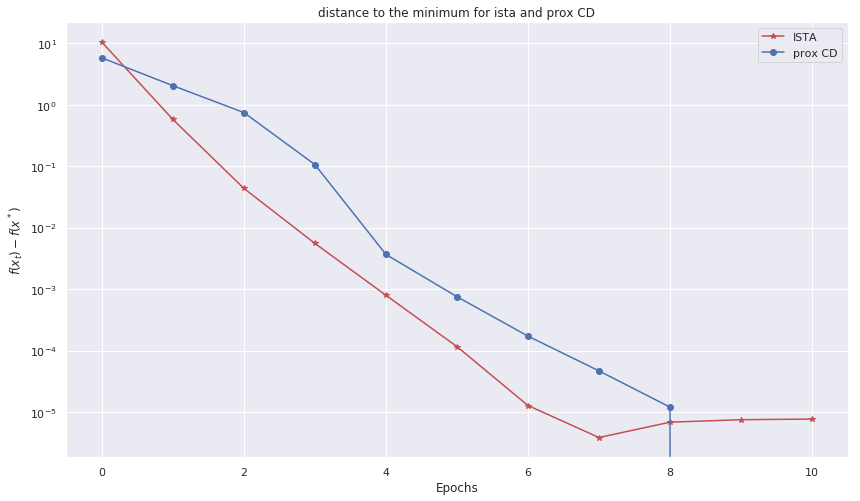

In [354]:
# comparing the performances of better proximal coordinate and ista
#in terms of distance to the last minimum obtained with better prox CD
plt.figure(figsize=(14,8))
plt.semilogy(w, 'r*-', label="ISTA")
plt.semilogy(v, 'o-',label="prox CD")
plt.title('distance to the minimum for ista and prox CD')
plt.xlabel('Epochs')
plt.ylabel('$f(x_t) - f(x^*)$')

plt.legend()
plt.show()

Code:
- a simple proximal gradient solver for the Lasso
- a prox CD solver for the Lasso
and compare them on this dataset. 
Do the plots in terms of epochs, not updates (to be fair to CD).

<div class="alert alert-info">
$\rightarrow$ In order to be fair to CD, we did the plots in terms of epochs.We ran the prox CD algorithm for 10 iterations and  the ista algorithm for $ 10 *n_{features}$ iterations( and pick the objective values every $n_{features}$ iterations )  since the prox CD algorithm has to go through $n_{features}$ updates at each iteration.   

$\rightarrow$ Both algorithms converges to the same minimum   
$\rightarrow$ We can not confirm that one is faster than the other since thay have nearly the same curve. To reach the minimum, prox CD needs 8 epochs with $n_{features}$ updates at each epoch and ista needs 6 epochs, meaning $6 * n_{features}$ iterations.


</div>